In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
import datetime
import gmplot
import matplotlib.colors as cl
import geopandas as gpd
import time

from sklearn.neighbors import NearestNeighbors

### Functions

In [2]:
def distance(longitude1,latitude1,longitude2,latitude2):
    
    #this is the same as the Haversine metric from sklearn which is output as A in nearest neighbor match below
    #convert from decimal degrees to radians
    long1 = np.radians(longitude1)
    long2 = np.radians(longitude2)
    lati1 = np.radians(latitude1)
    lati2 = np.radians(latitude2)
    
    dlong = long2 - long1
    dlati = lati2 - lati1
    
    #haversine formula for a great circle distance
    a = np.square(np.sin(dlati/2))+np.multiply(np.multiply(np.cos(lati1),np.cos(lati2)),np.square(np.sin(dlong/2)))
    c = 2 * np.arcsin(np.sqrt(a))
    
    r = 3955.082 #earth's radius in miles at London (0 elevation)
    
    return c*r

def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)
        
## following three functions from Greg McCracken
# usuage examples with accident dataframe "df"
# df = df.loc[is_str(df.Time.values),:]  (this would get rid of any None in a string feature. get_hour won't work with Nones)
# df[['y','m','d']] = get_ymd(df.Date.values)
# df['h'] = get_hour(df.Time.values)

def is_str(x):
    Nx = len(x)
    I = np.ones(Nx).astype(bool)
    for ii in range(Nx):
        if type(x[ii]) != str:
            I[ii] = False
    return I

def get_hour(T):
    Nt = len(T)
    H = np.zeros(Nt).astype(int)
    for ii in range(Nt):
        s = T[ii].split(':')
        h = int(s[0])
        m = int(s[1])
        if m > 30:
            h += 1
        H[ii] = h % 24
    return H

def get_ymd(D):
    Nd = len(D)
    ymd = np.zeros((Nd,3)).astype(int)
    for ii in range(Nd):
        s = D[ii].split('-')
        for nn in range(3):
            ymd[ii,nn] = int(s[nn])
    return ymd

def coord_retrieve(geometry):
    ## geometry needs to be an GeoSeries.explode(index_parts=True)
    
    length = len(geometry)
    
    lats = []
    longs = []
    
    for i in range(length):
        longs.append([coord[0] for coord in list(geometry[i].coords)])
        lats.append([coord[1] for coord in list(geometry[i].coords)])
        
    return lats,longs

def st2bool(x):
    x[x=='TRUE'] = True
    x[x=='FALSE'] = False
    return x

## Load in Data

In [3]:
##arrays needed for data sorting

#road class conversion of CYCLANDS 1st_Road_Class and 2nd_Road_Class variables
#note that 'na' corresponds to no 2nd road. 1st_Road_class does not have these values (-1)
road_classes = np.array(['','M','A(M)','A','B','C','U','na'])

##upper left, lower right corners of Greater London (lat,long)
corners = [(51.68863717738605, -0.5468983269149709),(51.28157836053724, 0.3732066186882609)]

##upper left, lower right corners of Central London (lat,long)
# corners = [(51.543,-0.179),(51.475,0.023)]

In [4]:
#collision data from CYCLANDS
collisions = pd.read_csv('../../code-2022/Final Project/uk_gov/cycling_safety_uk_gov.csv',parse_dates=['Date'])
#combine road_class and road_name variables to match single variable formatting of aadf
collisions['Road_name'] = road_classes[collisions['1st_Road_Class'].values].astype(object)+collisions['1st_Road_Number'].apply(str).values
collisions['Road_name2'] = road_classes[collisions['2nd_Road_Class'].values].astype(object)+collisions['2nd_Road_Number'].apply(str).values

#remove 0 road number from U and C road classes to match aadf (these are just filler road numbers and not real numbes)
collisions.Road_name = collisions.Road_name.str.replace('U0','U')
collisions.Road_name = collisions.Road_name.str.replace('C0','C')
collisions.Road_name2 = collisions.Road_name2.str.replace('U0','U')
collisions.Road_name2 = collisions.Road_name2.str.replace('C0','C')

In [5]:
#annual average daily flow traffic data from https://roadtraffic.dft.gov.uk
aadf = pd.read_csv('../../code-2022/Final Project/uk_gov/dft_traffic_counts_aadf.csv',low_memory=False,parse_dates=['Year'])

In [6]:
advanced_stop_line_url = '../Data/Dan_data/CyclingInfrastructure/Lines/advanced_stop_line.json'
cycle_lane_track_url = '../Data/Dan_data/CyclingInfrastructure/Lines/cycle_lane_track.json'

In [7]:
# advanced_stop_line = gpd.read_file(advanced_stop_line_url)
cycle_lane_track = gpd.read_file(cycle_lane_track_url)

In [8]:
aadf[cycle_lane_track.columns[:-3]] = np.nan

In [9]:
#add boolean variable for in London
collisions['in_london']=[(collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()[0]

In [10]:
collisions['aadf_'+aadf.columns] = np.nan
collisions['distance_to_cp'] = np.nan
collisions['match'] = False

## geojson matching

In [22]:
##This was already run and saved

# lats_coords = np.empty(len(cycle_lane_track),dtype=object)
# longs_coords = np.empty(len(cycle_lane_track),dtype=object)

# start = time.time()

# for i in range(len(cycle_lane_track)):
    
#     lats_coords[i],longs_coords[i] = coord_retrieve(cycle_lane_track.geometry.explode(index_parts=True)[i])
    
#     if i % 100 == 0:
#         print(i,time.time()-start)

In [23]:
# np.savez('longs_lats',longs=longs_coords,lats=lats_coords)

In [11]:
saved = np.load('longs_lats.npz',allow_pickle=True)

In [12]:
long_means = np.empty(len(saved['longs']))
lat_means = np.empty(len(saved['lats']))

for idx,i in enumerate(saved['longs']):
    long = np.array(i,dtype=object)
    long_means[idx] = np.mean(long).mean()
        
for idx,i in enumerate(saved['lats']):
    lat = np.array(i,dtype=object)
    lat_means[idx] = np.mean(lat).mean()

In [13]:
feature_means = pd.DataFrame({'Latitude':lat_means,'Longitude':long_means})

k_neighbor = 5000

#slice data within Greater London
aadf_year = aadf[(aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()

#find nearest k_neighbor aadf cp neighbors to collisions
#haversine metric used here with lat/long converted to radians. Euclidean metric glives slightly wrong ordering of neighbors
#A is distance from collision to each neighbor
#B is aadf index of neighbor
#A and B are of size (len(collisions+year),k_neighbor)
neigh = NearestNeighbors(n_neighbors=k_neighbor,metric='haversine')
neigh.fit(np.radians(feature_means[['Latitude','Longitude']]))
A,B = neigh.kneighbors(np.radians(aadf_year[['Latitude','Longitude']]))

#within = np.argwhere(A.flatten()*3955.082 < 0.1).flatten()

# print(aadf_year.iloc[B[within].flatten()].Year.value_counts())
# print()
# print(aadf_year.iloc[B[within].flatten()].Count_point_id.value_counts())
# print()
# print()

KeyboardInterrupt: 

In [ ]:
feature_id = np.empty(len(aadf),dtype=object)
# feature_id[:] = np.nan
svdate = np.empty(len(aadf),dtype=object)
# svdate[:] = np.nan
clt_colour = np.empty(len(aadf),dtype=object)
# clt_colour[:] = np.nan
borough = np.empty(len(aadf),dtype=object)
# borough[:] = np.nan

indices = np.arange(0,len(aadf))

london_mask = np.argwhere(((aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])).values)

for idx in range(len(aadf_year)):
    
    london_idx = london_mask[idx][0]
    
    mask = B[idx][A[idx]*3955.082 < 0.1]
    values = cycle_lane_track.iloc[mask][features].apply(st2bool).any(axis=0).values
    
    aadf.loc[aadf.index == london_idx,features] = values
    
    feature_id[london_idx] = [cycle_lane_track.iloc[mask].FEATURE_ID.values.tolist()]
    svdate[london_idx] = [cycle_lane_track.iloc[mask].SVDATE.values.tolist()]
    clt_colour[london_idx] = [cycle_lane_track.iloc[mask].CLT_COLOUR.values.tolist()]
    borough[london_idx] = [cycle_lane_track.iloc[mask].BOROUGH.values.tolist()]
    
    # aadf.loc[aadf.Count_point_id == count_id,'FEATURE_ID'] = pd.Series([cycle_lane_track.iloc[within].iloc[mask].FEATURE_ID.values])
    # aadf.loc[aadf.Count_point_id == count_id,'SVDATE'] = pd.Series([cycle_lane_track.iloc[within].iloc[mask].SVDATE.values])
    # aadf.loc[aadf.Count_point_id == count_id,'CLT_COLOUR'] = pd.Series([cycle_lane_track.iloc[within].iloc[mask].CLT_COLOUR.values])
    # aadf.loc[aadf.Count_point_id ==                    count_id,'BOROUGH'] = pd.Series([cycle_lane_track.iloc[within].iloc[mask].BOROUGH.values])

aadf['FEATURE_ID'] = feature_id
aadf['SVDATE'] = svdate
aadf['CLT_COLOUR'] = clt_colour
aadf['BOROUGH'] = borough

In [ ]:
aadf_year = aadf[(aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()

In [ ]:
aadf_london_col_years = aadf_year[pd.DataFrame(aadf_year.Year.dt.year.tolist(), index=aadf_year.index).isin(np.arange(2005,2019)).any(axis=1).values]

In [55]:
aadf_london_col_years.to_csv('./aadf_features_london_colyears.csv',index=False)

In [58]:
len(aadf_london_col_years)

38440

In [56]:
aadf_london_col_years.CLT_CARR.value_counts()

False    20941
True     17499
Name: CLT_CARR, dtype: int64

In [96]:
# feature_lengths = np.zeros(len(A))

# for idx,a in enumerate(A):
#     link_length = aadf_year.iloc[idx].Link_length_miles
#     if np.isnan(link_length):
#         link_length = 0.1
#     feature_lengths[idx] = np.count_nonzero(a*3955.082 < link_length)
#     if feature_lengths[idx] == 5000:
#         print(idx)

In [16]:
feature_means = pd.DataFrame({'Latitude':lat_means,'Longitude':long_means})

k_neighbor = 1

#slice data within Greater London
aadf_year = aadf[(aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()

#find nearest k_neighbor aadf cp neighbors to collisions
#haversine metric used here with lat/long converted to radians. Euclidean metric glives slightly wrong ordering of neighbors
#A is distance from collision to each neighbor
#B is aadf index of neighbor
#A and B are of size (len(collisions+year),k_neighbor)
neigh = NearestNeighbors(n_neighbors=k_neighbor,radius=1,metric='haversine')
neigh.fit(np.radians(aadf_year[['Latitude','Longitude']]))
A,B = neigh.kneighbors(np.radians(feature_means[['Latitude','Longitude']]),k_neighbor)

within = np.argwhere(A.flatten()*3955.082 < 0.1).flatten()

print(aadf_year.iloc[B[within].flatten()].Year.value_counts())
print()
print(aadf_year.iloc[B[within].flatten()].Count_point_id.value_counts())
print()
print()

2018-01-01    1472
2019-01-01    1111
2000-01-01     893
2021-01-01     741
2020-01-01     679
2008-01-01     519
2009-01-01     411
2001-01-01     360
2003-01-01     341
2002-01-01     308
2017-01-01     176
2010-01-01     170
2006-01-01     166
2004-01-01     163
2005-01-01     163
2007-01-01     162
2011-01-01     139
2012-01-01     124
2014-01-01     104
2013-01-01      98
2016-01-01      95
2015-01-01      82
Name: Year, dtype: int64

16188     38
16100     30
47892     27
70193     27
46201     26
          ..
74531      1
78386      1
942310     1
803377     1
810983     1
Name: Count_point_id, Length: 1926, dtype: int64




Text(0, 0.5, '# features')

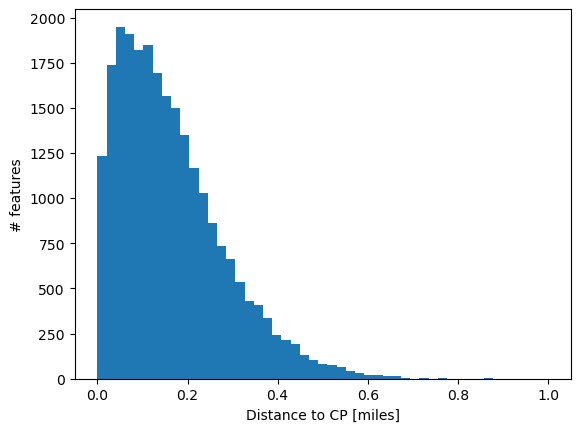

In [17]:
plt.hist(A*3955.082,bins=np.linspace(0,1));
plt.xlabel('Distance to CP [miles]')
plt.ylabel('# features')

In [27]:
features = ['CLT_CARR', 'CLT_SEGREG', 'CLT_STEPP',
       'CLT_PARSEG', 'CLT_SHARED', 'CLT_MANDAT', 'CLT_ADVIS', 'CLT_PRIORI',
       'CLT_CONTRA', 'CLT_BIDIRE', 'CLT_CBYPAS', 'CLT_BBYPAS', 'CLT_PARKR',
       'CLT_WATERR', 'CLT_PTIME']

In [20]:
feature_id = np.empty(len(aadf),dtype=object)
# feature_id[:] = np.nan
svdate = np.empty(len(aadf),dtype=object)
# svdate[:] = np.nan
clt_colour = np.empty(len(aadf),dtype=object)
# clt_colour[:] = np.nan
borough = np.empty(len(aadf),dtype=object)
# borough[:] = np.nan

indices = np.arange(0,len(aadf))

for idx,count_id in enumerate(aadf_year.iloc[B[within].flatten()].Count_point_id.unique()):
    
    mask = aadf_year.iloc[B[within].flatten()].Count_point_id.values == count_id
    values = cycle_lane_track.iloc[within].iloc[mask][features].apply(st2bool).any(axis=0).values
    
    aadf.loc[aadf.Count_point_id == count_id,features] = values
    
    mask_all = (aadf.Count_point_id == count_id).values
    
    feature_id[indices[mask_all]] = [cycle_lane_track.iloc[within].iloc[mask].FEATURE_ID.values.tolist()]
    svdate[indices[mask_all]] = [cycle_lane_track.iloc[within].iloc[mask].SVDATE.values.tolist()]
    clt_colour[indices[mask_all]] = [cycle_lane_track.iloc[within].iloc[mask].CLT_COLOUR.values.tolist()]
    borough[indices[mask_all]] = [cycle_lane_track.iloc[within].iloc[mask].BOROUGH.values.tolist()]
    
    # aadf.loc[aadf.Count_point_id == count_id,'FEATURE_ID'] = pd.Series([cycle_lane_track.iloc[within].iloc[mask].FEATURE_ID.values])
    # aadf.loc[aadf.Count_point_id == count_id,'SVDATE'] = pd.Series([cycle_lane_track.iloc[within].iloc[mask].SVDATE.values])
    # aadf.loc[aadf.Count_point_id == count_id,'CLT_COLOUR'] = pd.Series([cycle_lane_track.iloc[within].iloc[mask].CLT_COLOUR.values])
    # aadf.loc[aadf.Count_point_id == count_id,'BOROUGH'] = pd.Series([cycle_lane_track.iloc[within].iloc[mask].BOROUGH.values])

aadf['FEATURE_ID'] = feature_id
aadf['SVDATE'] = svdate
aadf['CLT_COLOUR'] = clt_colour
aadf['BOROUGH'] = borough

In [93]:
overlap_borough = []

for idx,count_id in enumerate(aadf_year.iloc[B[within].flatten()].Count_point_id.unique()):
    
    mask = aadf_year.iloc[B[within].flatten()].Count_point_id.values == count_id
    boroughs = cycle_lane_track.iloc[within].iloc[mask].BOROUGH.values
    
    if len(np.unique(boroughs[boroughs != np.array(None)])) > 1:
        # print(count_id)
        # print(cycle_lane_track.iloc[within].iloc[mask].BOROUGH)
        # print()
        overlap_borough.append(count_id)

In [40]:
for idx in np.random.choice(len(A),10):
    
    link_length_nan = False
    
    link_length = aadf_year.iloc[idx].Link_length_miles
    if np.isnan(link_length):
        link_length = 0.1
        link_length_nan = True

    idxs = B[idx][A[idx]*3955.082 < 0.1]

    lats = saved['lats'][idxs]
    longs = saved['longs'][idxs]

    gmap1 = gmplot.GoogleMapPlotter(aadf_year.iloc[idx].Latitude,aadf_year.iloc[idx].Longitude,16,apikey=api_key)

    for i in range(len(lats)):
        for j in range(len(lats[i])):
            gmap1.plot(lats[i][j], longs[i][j],'red', edge_width = 3)

    mark_long = aadf_year.iloc[idx].Longitude
    mark_lat = aadf_year.iloc[idx].Latitude
    road_name = aadf_year.iloc[idx].Road_name

    gmap1.marker(mark_lat,mark_long,color='green')
    gmap1.text(mark_lat,mark_long,text=road_name,color='green')
    
    if link_length_nan:
        gmap1.circle(mark_lat,mark_long,color='yellow',alpha=0.5,radius=160.934)
    else:
        gmap1.circle(mark_lat,mark_long,color='green',alpha=0.5,radius=160.934)

    gmap1.draw('../Plots/'+str(idx)+'.html')

In [98]:
lats = saved['lats'][within]
longs = saved['longs'][within]

# for count_id in aadf_year.iloc[B[within].flatten()].Count_point_id.value_counts().index.values[:10]:
for count_id in overlap_borough[:10]:

    mask = aadf_year.iloc[B[within].flatten()].Count_point_id.values == count_id

    gmap1 = gmplot.GoogleMapPlotter(feature_means.iloc[within].iloc[mask].Latitude.values[0],feature_means.iloc[within].iloc[mask].Longitude.values[0],16,apikey=api_key)

    for i in range(len(lats[mask])):
        for j in range(len(lats[mask][i])):
            gmap1.plot(lats[mask][i][j], longs[mask][i][j],'red', edge_width = 3)
            
    mark_long = aadf_year.iloc[B[within].flatten()][aadf_year.iloc[B[within].flatten()].Count_point_id.values == count_id].Longitude.values
    mark_lat = aadf_year.iloc[B[within].flatten()][aadf_year.iloc[B[within].flatten()].Count_point_id.values == count_id].Latitude.values
    road_name = aadf_year.iloc[B[within].flatten()][aadf_year.iloc[B[within].flatten()].Count_point_id.values == count_id].Road_name.values

    for i in range(len(mark_long)):
        gmap1.marker(mark_lat[i],mark_long[i],color='green')
        gmap1.text(mark_lat[i],mark_long[i],text=road_name[i],color='green')

    gmap1.draw('../Plots/'+str(count_id)+'.html')

In [38]:
api_key = get_file_contents('../../code-2022/Final Project/Keys/google_maps.txt')

In [289]:
lats = saved['lats']
longs = saved['longs']

for j in np.random.choice(within,5):

    gmap1 = gmplot.GoogleMapPlotter(feature_means.iloc[j].Latitude,feature_means.iloc[j].Longitude,16,apikey=api_key)
    
    for i in range(len(lats[j])):
        gmap1.plot(lats[j][i], longs[j][i],'red', edge_width = 6)
        
    gmap1.marker(aadf_year.iloc[B[j]].Latitude,aadf_year.iloc[B[j]].Longitude,color='green')
    road_name = aadf_year.iloc[B[j]].Road_name.values[0]
    gmap1.text(aadf_year.iloc[B[j]].Latitude,aadf_year.iloc[B[j]].Longitude, text=road_name,color='green')

    gmap1.draw('../Plots/'+str(j)+'.html')

## Geomatch data

In [41]:
matches = 0
london_col = 0
london_col_nonan = 0
too_fars = 0

#how many aadf neighbors to compare each collision to. Typically each year has ~25 that have k>10.
k_neighbor = 50

for year in np.arange(2005,2019):
    
    #slice data on year and within Greater London
    aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
    collisions_year = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()
    
    aadf_mask = (aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])
    col_mask = (collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])
    
    #find nearest k_neighbor aadf cp neighbors to collisions
    #haversine metric used here with lat/long converted to radians. Euclidean metric glives slightly wrong ordering of neighbors
    #A is distance from collision to each neighbor
    #B is aadf index of neighbor
    #A and B are of size (len(collisions+year),k_neighbor)
    neigh = NearestNeighbors(n_neighbors=k_neighbor,radius=1,metric='haversine')
    neigh.fit(np.radians(aadf_year[['Latitude','Longitude']]))
    A,B = neigh.kneighbors(np.radians(collisions_year[['Latitude','Longitude']]),k_neighbor)
    
    #find index of correct neighbor match
    match_idx = np.zeros((len(B),k_neighbor))
    
    #loop through k_neighbors and mark which ones have Road_name that matches 1st collision road name
    for i in range(k_neighbor):
        match_idx[aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name.values,i] = 1
    
    #find closest neighbor with matching road names
    #need to set collisions with no match to -1 to not be confused with those where first neighbor (i.e. k=0) is match
    invalid_val = -1
    no_match = match_idx != 0
    check = np.where(no_match.any(axis=1), no_match.argmax(axis=1), invalid_val)    #this is 1d array of len(collisions_year) of which neighbor in B[i,:] is correct match (-1 is no match)
    
    #for collisions with no aadf match (i.e. check[i]=-1), look at 2nd labeled road in collision (Road_name2)
    for i in range(k_neighbor):
        match2 = aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name2.values
        match_idx[match2 & (check == -1),i] = 1
    
    #repeat this process now that 2nd road name matches have been filled in
    invalid_val = -1
    no_match = match_idx != 0
    check = np.where(no_match.any(axis=1), no_match.argmax(axis=1), invalid_val)
    
    #create boolean mask of matches
    match = np.where(check.astype(int) >= 0,True,False)
    
    #calculate distance from collision to match
    dist = A[np.arange(B.shape[0]),check]*3955.082
    
    #how many correct matches are within Link_length_miles
    too_far = (dist[match] <= aadf_year.iloc[B[np.arange(B.shape[0]),check][match]].Link_length_miles.values)
    
    #add correct aadf matches to collisions
    collisions.loc[np.where(col_mask)[0][match],'aadf_'+aadf.columns] = aadf.loc[aadf_mask].iloc[B[np.arange(B.shape[0]),check]][match].values
    #add correct matches to collisions
    collisions.loc[np.where(col_mask)[0][match][too_far],'match'] = True
    #add distance_to_cp to collisions
    collisions.loc[np.where(col_mask)[0][match][too_far],'distance_to_cp'] = A[np.arange(B.shape[0]),check][match][too_far]*3955.082
    
    ##calculate statistics
    
    B_match = B[np.arange(B.shape[0]),check][match]
    
    #count collisions in London
    london_col += len(collisions_year)
    london_col_nonan += len(collisions_year)
    
    #how many matches
    matches += match.sum()
    
    #of unmatched collisions, how many were U/C roads
    #try/except used as sometimes all U roads have matches
    try:
        Unlabeled = collisions_year[check == -1].Road_name.value_counts().loc[['U','C']].values.sum()/(check == -1).sum()
    except:
        Unlabeled = collisions_year[check == -1].Road_name.value_counts().loc[['C']].values.sum()/(check == -1).sum()

    #log how many total are outside boundary
    too_fars += too_far.sum()
    
    #which percent of collisions outside of Link_length_miles are due to nan Link_length_miles
    nan_outside = np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()/(np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()+(dist[match] > aadf_year.iloc[B_match].Link_length_miles.values).sum())
    
    #remove london collisions from count with nan Link_length_miles
    london_col_nonan -= np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()
    
    #how many collisions are within Link_length_miles
    #needed to cauclate large k's within boundaries
    too_far_all = (dist <= aadf_year.iloc[B[np.arange(B.shape[0]),check]].Link_length_miles.values)
        
    
    print(year)
    print('mean distance to CP:',dist[match].mean())
    print('median distance to CP:',np.median(dist[match]))
    print('max distance to CP:',dist[match].max())
    print('min distance to CP:',dist[match].min())
    print()
    print('mean distance to CP within tracker boundary:',dist[match][too_far].mean())
    print('median distance to CP within tracker boundary:',np.median(dist[match][too_far]))
    print('max distance to CP within tracker boundary:',dist[match][too_far].max())
    print('min distance to CP within tracker boundary:',dist[match][too_far].min())
    print()
    print('Correct geo match:',match.sum())
    print('Correct geo match within tracker boundary:',too_far.sum())
    print('k>9 matches inside boundary',np.where((check > 9) & too_far_all,1,0).sum())
    print('largest k within boundary',np.max(check[too_far_all]))
    print('% outside boundary with nan value',nan_outside)
    print()
    print('Unlabeled unmatched collisions:',Unlabeled)
    print()
    print('Total London collisions:',len(collisions_year))
    print()
    print('% matched:',match.sum()/len(collisions_year))
    print('% matched in boundary:',too_far.sum()/len(collisions_year))
    print('% matched in boundary (not counting nan):',too_far.sum()/(len(collisions_year)-np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()))
    
    print()
    print()
    print()

print('total')
print('Correct geo match:',matches)
print('Correct geo match within tracker boundary:',too_fars)
print('Total London collisions:',london_col)
print('% matched:',matches/london_col)
print('% matched in boundary:',too_fars/london_col)
print('% matched in boundary (not counting nan):',too_fars/london_col_nonan)

C:\Users\tuthill.15\Anaconda3\envs\geo_env\Lib\site-packages\pandas\core\dtypes\cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


2005
mean distance to CP: 0.4139035254218025
median distance to CP: 0.25003217948595274
max distance to CP: 5.358011966852259
min distance to CP: 0.0024900736781821777

mean distance to CP within tracker boundary: 0.2007601698757958
median distance to CP within tracker boundary: 0.1295936783983048
max distance to CP within tracker boundary: 2.612617688753044
min distance to CP within tracker boundary: 0.0024900736781821777

Correct geo match: 3073
Correct geo match within tracker boundary: 1803
k>9 matches inside boundary 23
largest k within boundary 46
% outside boundary with nan value 0.8913385826771654

Unlabeled unmatched collisions: 0.176

Total London collisions: 3323

% matched: 0.924766777008727
% matched in boundary: 0.5425820042130605
% matched in boundary (not counting nan): 0.8229119123687814



2006
mean distance to CP: 0.3971747976624115
median distance to CP: 0.2433006112990845
max distance to CP: 4.939897207887375
min distance to CP: 0.0025593925852251775

mean distance

In [43]:
collisions.to_csv('./combined_collisions_v3.csv',index=False)

## Plot results

In [96]:
api_key = get_file_contents('../../code-2022/Final Project/Keys/google_maps.txt')

Collision: 3302
Neighbor index of match: 0
Found match: True
Match within boundary: True


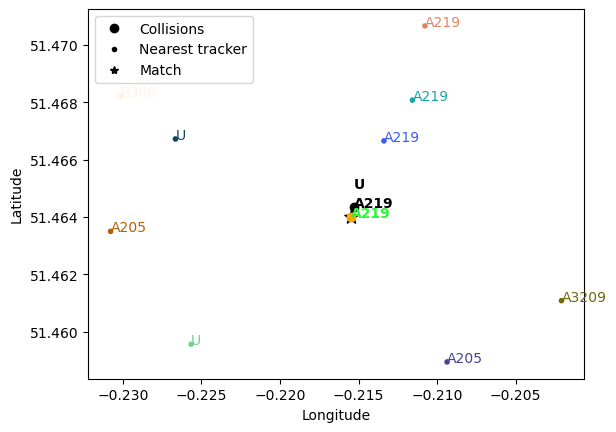

In [22]:
#index of collision to plot
plotN = np.random.randint(len(collisions_year))

#how many neighbors to plot
p_neighbor = 10

#if True will create .html with labeled map
gmp = False

print('Collision:',plotN)
print('Neighbor index of match:',check[plotN])
print('Found match:',match[plotN])
print('Match within boundary:',too_far_all[plotN])

#randomly create colors for neighbors
colors = np.random.rand(p_neighbor,3)

##plot collision
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#collision marker
ax.scatter(collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude,c='black')
#collision text Road_name
ax.annotate(collisions_year.iloc[plotN].Road_name, (collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude),color='black',weight='bold')

##plot neighbors
#neighbor markers
ax.scatter(aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Latitude.values,c=colors,marker='.')
#neibhor text Road_name
for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Road_name.values,aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Latitude.values)):
    if i == check[plotN]:
        ax.annotate(txt, (long,lat),color=colors[i],weight='bold')
    else:
        ax.annotate(txt, (long,lat),color=colors[i])

#if match, plot start on matched neighbor
if check[plotN] != -1:
    ax.scatter(aadf_year.iloc[B[plotN,check[plotN]].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN,check[plotN]].flatten().tolist()].Latitude.values,c='black',marker='*',s=100)

#plot text of collision Road_name2
yspan = np.diff(ax.get_ylim())[0]   #calculates how far above first text to place second text
ax.annotate(collisions_year.iloc[plotN].Road_name2, (collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude+yspan/20),color='black',weight='bold')    

#collision marker
ax.scatter(collisions.loc[np.where(col_mask)[0][plotN]].aadf_Longitude,collisions.loc[np.where(col_mask)[0][plotN]].aadf_Latitude,c='orange')

##create legend
#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='.',linestyle='')
matchArtist = plt.Line2D((0,1),(0,0), color='k',marker='*',linestyle='')

#plot legend
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist,matchArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker','Match'])

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

if gmp:
    gmap1 = gmplot.GoogleMapPlotter(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude,16,apikey=api_key)

    gmap1.marker(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude, color='blue')
    road_name = collisions_year.iloc[plotN].Road_name
    gmap1.text(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude, text=road_name,color='blue')
    road_name = collisions_year.iloc[plotN].Road_name2
    gmap1.text(collisions_year.iloc[plotN].Latitude-0.0002,collisions_year.iloc[plotN].Longitude, text=road_name,color='blue')

    gmap1.scatter(aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,c='red')
    for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values)):
        if i != check[plotN]:
            gmap1.text(lat,long,txt,color='red')

    gmap1.marker(aadf_year.iloc[B[plotN,check[plotN]]].Latitude,aadf_year.iloc[B[plotN,check[plotN]]].Longitude,color='green')
    road_name = aadf_year.iloc[B[plotN,check[plotN]]].Road_name
    gmap1.text(aadf_year.iloc[B[plotN,check[plotN]]].Latitude,aadf_year.iloc[B[plotN,check[plotN]]].Longitude, text=road_name,color='green')

    gmap1.draw('./Plots/map'+str(plotN)+'.html')

In [28]:
combined_collisions = pd.read_csv('./DataFrames/combined_collisions.csv',parse_dates=['Date','aadf_Year'])

In [30]:
combined_collisions == collisions

,Unnamed: 0,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,...,aadf_HGVs_2_rigid_axle,aadf_HGVs_3_rigid_axle,aadf_HGVs_4_or_more_rigid_axle,aadf_HGVs_3_or_4_articulated_axle,aadf_HGVs_5_articulated_axle,aadf_HGVs_6_articulated_axle,aadf_All_HGVs,aadf_All_motor_vehicles,distance_to_cp,match
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
1,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250958,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
250959,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
250960,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
250961,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True


In [31]:
combined_collisions.head()

,Unnamed: 0,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,...,aadf_HGVs_2_rigid_axle,aadf_HGVs_3_rigid_axle,aadf_HGVs_4_or_more_rigid_axle,aadf_HGVs_3_or_4_articulated_axle,aadf_HGVs_5_articulated_axle,aadf_HGVs_6_articulated_axle,aadf_All_HGVs,aadf_All_motor_vehicles,distance_to_cp,match
0,0,200501BS00024,524700.0,180880.0,-0.204346,51.513039,1,3,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1,200501BS00032,524470.0,180980.0,-0.207623,51.513988,1,3,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2,200501BS70004,524870.0,181880.0,-0.201543,51.521988,1,3,2,1,...,214.0,36.0,5.0,2.0,1.0,0.0,258.0,16736.0,0.000039,True
3,3,200501BS70009,525840.0,177020.0,-0.189301,51.478096,1,3,2,1,...,579.0,162.0,63.0,8.0,9.0,18.0,839.0,31833.0,0.000031,True
4,4,200501BS70010,526940.0,177460.0,-0.173312,51.481804,1,3,2,1,...,542.0,48.0,10.0,25.0,5.0,1.0,631.0,25041.0,0.000003,True


In [32]:
collisions.head()

,Unnamed: 0,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,...,aadf_HGVs_2_rigid_axle,aadf_HGVs_3_rigid_axle,aadf_HGVs_4_or_more_rigid_axle,aadf_HGVs_3_or_4_articulated_axle,aadf_HGVs_5_articulated_axle,aadf_HGVs_6_articulated_axle,aadf_All_HGVs,aadf_All_motor_vehicles,distance_to_cp,match
0,0,200501BS00024,524700.0,180880.0,-0.204346,51.513039,1,3,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1,200501BS00032,524470.0,180980.0,-0.207623,51.513988,1,3,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2,200501BS70004,524870.0,181880.0,-0.201543,51.521988,1,3,2,1,...,214.0,36.0,5.0,2.0,1.0,0.0,258.0,16736.0,0.000039,True
3,3,200501BS70009,525840.0,177020.0,-0.189301,51.478096,1,3,2,1,...,579.0,162.0,63.0,8.0,9.0,18.0,839.0,31833.0,0.000031,True
4,4,200501BS70010,526940.0,177460.0,-0.173312,51.481804,1,3,2,1,...,542.0,48.0,10.0,25.0,5.0,1.0,631.0,25041.0,0.000003,True


In [293]:
i

0

In [58]:
aadf_year.iloc[B[j]].Road_name.values[0]

'A504'

In [76]:
cycle_lane_track.CLT_CARR.value_counts()

TRUE     13849
FALSE    11127
Name: CLT_CARR, dtype: int64

In [22]:
aadf_year.iloc[B[j]].Road_name

489713    A105
Name: Road_name, dtype: object

In [14]:
# # [line.coords for line in cycle_lane_track.geometry.unary_union]
# for i,line in enumerate(cycle_lane_track.geometry.explode()):
#     if i<100:
#         print(i,len(line.coords)) 
lengths_idx = []
lengths = []
for i,line in enumerate(cycle_lane_track.geometry):
    try:
        len(line.coords)
    except:
        lengths_idx.append(i)
        # len(cycle_lane_track.geometry[61].geoms)
        # print(len(cycle_lane_track.geometry[61].geoms))
        lengths.append(len(cycle_lane_track.geometry[i]))
    
# print()
# print(list(cycle_lane_track.geometry[62].coords))
# print()
# print(list(cycle_lane_track.geometry[63].coords))
# print()
# print(list(cycle_lane_track.geometry[64].coords))
# print()
# print(list(cycle_lane_track.geometry[65].coords))
# print()
# print(list(cycle_lane_track.geometry[66].coords))
# print()
# print(list(cycle_lane_track.geometry[67].coords))
# print()

# for i,line in enumerate(cycle_lane_track.geometry):
#     if i == 61:
#         print(i,line)
#         print()
#         line

/var/folders/gt/5r1jgnfs3c7g4r0lxgmqlx_c0000gn/T/ipykernel_39296/4005543166.py:14: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  lengths.append(len(cycle_lane_track.geometry[i]))


In [15]:
lengths_idx[np.argmax(lengths)]

24484

In [36]:
lengths_idx

[61,
 958,
 1656,
 2286,
 2892,
 3804,
 3818,
 4160,
 5369,
 5416,
 5448,
 5462,
 5500,
 5569,
 5721,
 5722,
 6189,
 6351,
 6492,
 6628,
 6986,
 9064,
 9434,
 9699,
 9814,
 9919,
 10077,
 10220,
 10678,
 10745,
 10789,
 10829,
 10971,
 11109,
 11126,
 11131,
 11151,
 11152,
 11323,
 11487,
 11515,
 11569,
 11614,
 11724,
 11790,
 11808,
 11813,
 11818,
 11833,
 11835,
 11837,
 11879,
 11881,
 11888,
 11897,
 11901,
 11937,
 11968,
 11988,
 11998,
 11999,
 12000,
 12010,
 12030,
 12037,
 12053,
 12057,
 12059,
 12060,
 12061,
 12144,
 12203,
 12251,
 12283,
 12300,
 12439,
 12457,
 12477,
 12481,
 12525,
 12534,
 12599,
 12601,
 12613,
 12624,
 12643,
 12645,
 12648,
 12651,
 12680,
 12682,
 12685,
 12687,
 12702,
 12708,
 12740,
 12755,
 12766,
 12768,
 12778,
 12780,
 12783,
 12791,
 12799,
 12800,
 12813,
 12818,
 12825,
 12854,
 12886,
 12891,
 12983,
 12987,
 13015,
 13023,
 13035,
 13083,
 13170,
 13279,
 13306,
 13352,
 13353,
 13417,
 13430,
 13431,
 13437,
 13475,
 13479,
 1350

In [202]:
len(cycle_lane_track.geometry[61].geoms)

6

In [82]:
list(cycle_lane_track.geometry[17670].coords)

[(-0.0842419361, 51.5488637639),
 (-0.0842413494, 51.5488420528),
 (-0.0842365078, 51.5487782377),
 (-0.0842239505, 51.5487235362),
 (-0.0841995042, 51.5486244306),
 (-0.0841598391, 51.5484593735),
 (-0.0841131889, 51.5482955563),
 (-0.0840944785, 51.5482196075),
 (-0.0840761135, 51.5481348894),
 (-0.0840430904, 51.5479952249),
 (-0.0837539291, 51.5469188482)]

In [90]:
len(cycle_lane_track)

24976

<AxesSubplot: >

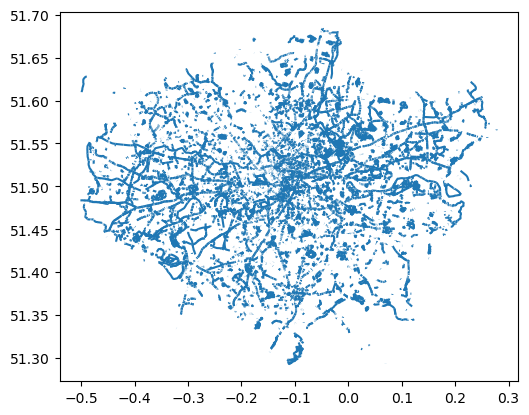

In [19]:
gpd.GeoSeries.plot(cycle_lane_track.geometry)

In [6]:
year = 2018
aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()

In [13]:
np.nanmean(aadf_year.Link_length_miles.values)

0.7282352941176472

In [12]:
aadf_year = aadf[(aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()

In [13]:
np.max(aadf_year.Link_length_miles)

8.57

In [11]:
aadf_year_meta = pd.read_csv('./aadf_year_meta.csv')

In [12]:
aadf_year_meta.head()

,Count_point_id,N_year,Year_start,Year_end,Max_year_gap
0,51,22,2000,2021,1
1,52,22,2000,2021,1
2,53,22,2000,2021,1
3,54,22,2000,2021,1
4,55,22,2000,2021,1
